# Pump-Probe Spectroscopy #


Last week, we looked at the nonlinear response of a Morse oscillator by calculating the absorption spectrum at low and high pulse amplitudes. We claimed that this signal corresponds roughly to a pump-probe spectrum in which the pump and the probe are overlapped in time. This week, we'll run a simulation that much more precisely describes pump-probe spectroscopy, this time with a variable time-delay between pump and probe.

## Background: Experimental Setup ##

Pump-probe spectroscopy is a nonlinear technique that, loosely speaking, can be understood as monitoring the *difference* in sample absorption with and without prior excitation. Experimentally, the sample is hit with two laser pulses, propagating along different axes as shown in the figure below. The *pump* pulse is "chopped" by a rapidly-rotating blade which blocks every other laser pulse. The *probe* pulse (which is not chopped) is used to measure an absorption spectrum with every laser pulse. The "pump-probe" signal is just the *difference* between probe-measured absorption spectra with and without the pump, i.e., "pump on minus pump off".


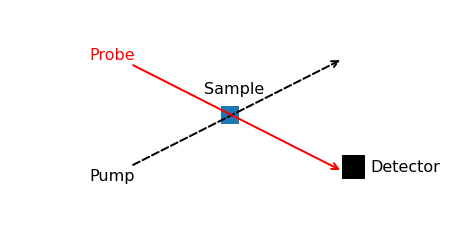

In [2]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
import matplotlib.patches as patches
import ipywidgets as widgets

plt.rc({'font.size': 22})

fig = plt.figure(figsize=(8,4))
ax = plt.gca()
ax.axis('equal')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.annotate("Pump", xy=(0.5, 0.25), xytext=(-0.63, -0.29), arrowprops=dict(arrowstyle="->", ls='dashed', linewidth=2), fontsize=16)
plt.annotate("Probe", xy=(0.5, -0.25), xytext=(-0.63, 0.25), arrowprops=dict(arrowstyle="->", linewidth=2, color='r'), fontsize=16, color='r')
ax.add_patch(patches.Rectangle((-0.04, -0.04),0.08,0.08,fill=True))
ax.add_patch(patches.Rectangle((0.5, -0.28),0.1,0.1,fill=True,color='k'))
plt.text(-0.12, 0.1, 'Sample', fontsize=16)
plt.text(0.625, -0.25, 'Detector', fontsize=16)
plt.axis('off')
plt.show()

## Response Function Contributions ##

Based simply on this description, it's possible (see Appendix) to deduce (in the short-pulse limit) that the measured pump-probe signal is proportional to the quantity
\begin{align}
    S^{(\text{pp})}(\omega) &\propto \varepsilon_\text{pump}^2 \varepsilon_\text{probe} \int d\omega_1 \left [ \tilde R_{yyyy}^{(3)}(-\omega_1, 0, \omega) + \tilde R_{yyyy}^{(3)}(\omega_1, 0, \omega) \right],
\end{align}
where $\varepsilon_\text{pump}$ and $\varepsilon_\text{probe}$ are amplitudes for the pump and probe fields, and $R_{yyyy}^{(3)}(\omega_1,\omega_2,\omega_3)$ is the Fourier-transformed third-order response tensor. The only constraint is that the frequency $\omega_1$ must be positive and near the laser excitation frequency. Thus the pump-probe signal is a linear combination of two response-function terms that oscillate with frequencies
* Near either plus or minus the laser excitation frequency in $\tau_1$,
* Near 0 in $\tau_2$, and 
* Again at optical frequencies in $\tau_3$ (usually near the laser excitation frequency). 

The two response function terms $\tilde R_{yyyy}^{(3)}(-\omega_1, 0, \omega)$ and $\tilde R_{yyyy}^{(3)}(\omega_1, 0, \omega)$ are called the *rephasing* and *nonrephasing* signals, respectively, and correspond to the wavevector sum conditions

**Rephasing:** $ \quad\quad {\bf k}_\text{sig} = - {\bf k}_1 + {\bf k}_2 + {\bf k}_3 $

**Nonrephasing:** $ \quad\quad {\bf k}_\text{sig} = + {\bf k}_1 - {\bf k}_2 + {\bf k}_3$. 

These are the same terms that contribute to two-dimensional correlation spectra. In fact, the primary difference between pump-probe spectroscopy and 2D correlation spectroscopy is that 2D spectroscopy resolves the frequency $\omega_1$ of the initial interaction *as well as* the frequency $\omega_\text{sig}$ of the final interaction. 


## Numerical Evaluation ##

To study this process numerically, we'll consider an experiment in which a Morse oscillator is excited by two Gaussian pulses, characterized by the fields ${\bf E}_{\text{pu}}$ (pump) and ${\bf E}_{\text{pr}}$ (probe). The total electric field that hits the sample will have the form
$${\bf E} = \varepsilon_\text{pu} {\bf E}_\text{pu} + \varepsilon_\text{pr} {\bf E}_\text{pr},$$
where the coefficients $\varepsilon_\text{pu}$ and $\varepsilon_\text{pr}$ scale the amplitude of the two pulses. In our simulation, we'll select out those components from the *total* response that have the same characteristics as the response function terms we just identified. Namely, we need signal that
1. Scales linearly with $\varepsilon_\text{probe}$,
2. Scales nonlinearly with $\varepsilon_\text{pump}$, and
3. Does not oscillate as a function of the time-delay between the pump and probe. (This corresponds to the fact that the second frequency argument in our response functions is zero.) 

Just as we did in our last exercise, we can select for signals with the correct scaling properties (requirements 1 and 2) by taking sums and differences of the *total* polarization under different amplitudes of the perturbing field. Specifically (see Appendix 2), the signal we want turns out to be 
$${\bf P}_\text{2pu,pr}^{(3)} \propto {\bf P}[2 \varepsilon_\text{pu},\varepsilon_\text{pr}] - {\bf P}[0,\varepsilon_\text{pr}] - {\bf P}[2 \varepsilon_\text{pu},0] - 2 \left( {\bf P}[\varepsilon_\text{pu},\varepsilon_\text{pr}] - {\bf P}[0,\varepsilon_\text{pr}] - {\bf P}[\varepsilon_\text{pu},0] \right)$$
Here the notation ${\bf P}[a_1,a_2]$ indicates the induced polarization in a simulation where the pump electric field has amplitude $a_1$ and the probe field has amplitude $a_2$. This is a quantity we can easily evaluate numerically by simply running simulations with different field amplitudes. 

Note, however, that this signal is **not** guaranteed to oscillate near zero frequency as a function of the time delay between the pulses. This is something that we'll have to check explicitly and, if necessary, filter in the frequency domain. 

In [3]:

def calc_accel(x,efield):
    ax = - 2.0*De*alpha*(np.exp(-alpha*x) - np.exp(-2.0*alpha*x))/M
    ax += Qo*efield/M
    #ax = -K*x/M
    return ax

def vv_step(x,vx,ax,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,1)/M
    xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
    axnew = calc_accel(xnew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    return xnew,vxnew,axnew

def gauss_pulse(t):
    return np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

def morse_energy(X):
    return De*(1.0 - np.exp(-alpha*X))**2


to = 150e-15
sigma = 50e-15
nu = 50e+12

tmax=5e-12      # Total simulation time in seconds
dt=2e-15     # Time-step in seconds
Nsteps=int(tmax/dt)
M=12*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,Nsteps)*dt   # Time axis (array of time steps)

gamma = 200.0e-12  # grams/second
kB = 1.38064852e-16                  # erg/K
Temp = 0.0                           # K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

wo = 6.28*50e12        # Oscillator (angular) frequency
W = wo
K = M*W**2

De = 1e+5*(kB*300.0)
alpha = np.sqrt(K/(2.0*De))
xtherm = np.sqrt(kB*Temp/(M*W**2))

c = 2.9979e+10
vaxis = np.fft.fftfreq(Nsteps)/(dt*c)

v1 = 1500
v2 = 1850

ndx1 = np.where(np.abs(vaxis-v1)==np.min(np.abs(vaxis-v1)))[0][0]
ndx2 = np.where(np.abs(vaxis-v2)==np.min(np.abs(vaxis-v2)))[0][0]

def calc_response(Efield):
    X = 0
    VX = 0
    AX = calc_accel(X,Efield[0])

    Mu = np.zeros((Nsteps))
    #fig,partPt,fieldPts,muPts = plot_potential(X,Efield)
    for n in range(0,Nsteps):
        X,VX,AX = vv_step(X,VX,AX,Efield[n])
        Mu[n] = np.mean(X)*Qo
        #if(n%1000==0):
            #update_plot(X,Efield,Mu,fig,partPt,fieldPts,muPts)
    return Mu


## Two-Pulse Response ##

As a first step, let's use this code to visualize what happens when our Morse oscillator is excited by pump and probe pulses. The code below plots the *total* induced polarization as a function of the time delay between pulses. Run the code and try to interpret what's happening. 

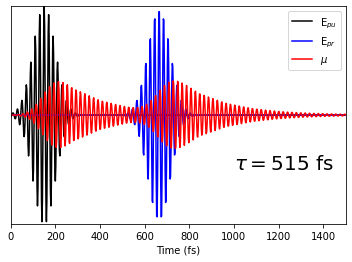

In [4]:
def two_pulse(b):

    plt.figure()
    Emax = 50e+4   # Maximum electric field in statV/cm
    pumpPts, = plt.plot(taxis*1e+15, 0.0*taxis, 'k')
    probePts, = plt.plot(taxis*1e+15, 0.0*taxis, 'b')
    muPts, = plt.plot(taxis*1e+15, 0.0*taxis, 'r')
    plt.xlabel('Time (fs)')
    plt.xlim([0,1500])
    plt.ylim([-1,1])
    plt.yticks([])
    txt = plt.text(1000, -0.5, '$\\tau = $'+str(int(0.0))+' fs', fontsize=20)
    plt.legend(['E$_{pu}$', 'E$_{pr}$', '$\mu$'])

    scfac = 4e+17*(Emax/(50e+4))
    for tau in np.arange(0, 1000e-15, 5e-15):
        Epump = Emax*gauss_pulse(taxis)
        Eprobe = Emax*gauss_pulse(taxis-tau)
        Mu = calc_response(Epump + Eprobe)
        pumpPts.set_ydata(Epump/Emax)
        probePts.set_ydata(Eprobe/Emax)
        muPts.set_ydata(Mu*scfac)
        txt.set_text('$\\tau = $'+str(int(tau*1e+15))+' fs')
        display.display(plt.gcf())
        display.clear_output(wait=True)
    display.display(twopulse_button)

        
twopulse_button = widgets.Button(
    description='Run Simulation',
    disabled=False
)

twopulse_button.on_click(two_pulse)
display.display(twopulse_button)

The main thing you probably notice is that the polarization seems to "beat" as a function of the time dealy $\tau$ between the pulses. This behavior *strongly* resembles the "quantum beating" behavior sometimes observed in nonlinear spectroscopies. Note, however, that these beats are determined entirely by linear response! They actually arise from interference between the oscillator's independent *linear* response terms to both pulses: When the time delay between the pulses is an integer multiple of the Morse oscillation period, the two linear response terms add constructively to enhance the signal. When the delay is a half-integer multiple of the oscillation period, the two linear response contributions interfere *destructively*, killing the signal. This interpretation is reinforced by the observation that the "beats" complete a full cycle every 20 fs, corresponding to the harmonic oscillation frequency of our Morse oscillator. 

To see nonlinear effects, we'll need to do some signal processing. The next code block evaluates the "two-pump/one probe" signal described in the introduction as a function of the inter-pulse delay $\tau$ **and** converts that response to the frequency domain in order to obtain a pump-probe-like signal. As in our last simulation, the frequency-domain response is divided by the frequency-spectrum of the probe pulse to produce an absorptive (difference) signal. 

Note, however, that this code does **not** ensure that the measured signal contains no (high-frequency) oscillations as a function of $\tau$, as should be the case in a true pump-probe measurement. For that we'll have to filter in the Fourier-domain. Let's first take a look at the response and then discuss filtering. 

Button(description='Run Simulation', style=ButtonStyle())

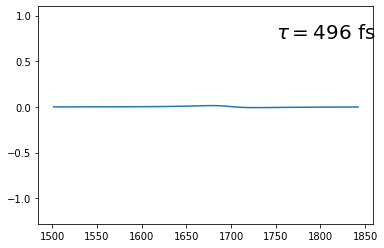

In [27]:
def run_dynamics(b):
    global SpecMat
    tauStep = 4*1e-15
    Tau = np.arange(0e-15, 500e-15, tauStep)
    Emax = 50e+4
    scfac = 8e+24*(Emax/(50e+4))
    for n in range(0, len(Tau)):
        tau = Tau[n]
        Epump = Emax*gauss_pulse(taxis)
        Eprobe = Emax*gauss_pulse(taxis-tau)

        Mu21 = calc_response(2.0*Epump + Eprobe)
        Mu20 = calc_response(2.0*Epump)
        Mu11 = calc_response(Epump + Eprobe)
        Mu01 = calc_response(Eprobe)
        Mu10 = calc_response(Epump)

        MuPP = (Mu21 - 2.0*Mu11) - (Mu20 - 2.0*Mu10) + Mu01
        fMuPP = np.fft.fft(MuPP)
        fEprobe = np.fft.fft(Eprobe)

        Sig = -np.imag(fMuPP/fEprobe)

        if n==0:
            SpecMat = np.zeros((len(vaxis[ndx1:ndx2]),len(Tau)))
            ppPts, = plt.plot(vaxis[ndx1:ndx2], Sig[ndx1:ndx2]*scfac)
            txt = plt.text(1750, 0.75, '$\\tau$ = 0 fs', fontsize=20)
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            ppPts.set_ydata(Sig[ndx1:ndx2]*scfac)
            txt.set_text('$\\tau = $'+str(int(tau*1e+15))+' fs')
            display.display(plt.gcf())
            display.clear_output(wait=True)

        SpecMat[:,n] = Sig[ndx1:ndx2]

    display.display(rundynamics_button)
    return SpecMat

SpecMat = []
tauStep = 4*1e-15
Tau = np.arange(0e-15, 500e-15, tauStep)

rundynamics_button = widgets.Button(
    description='Run Simulation',
    disabled=False
)

rundynamics_button.on_click(run_dynamics)
display.display(rundynamics_button)

The signal again oscillates as a function of the inter-pulse delay. If you watch carefully, however, you may notice that, this time, the beats have a period of roughly 10 fs, corresponding to *twice* the Morse oscillator frequency. To see this more clearly, let's transform to the Fourier domain. The code below plots the pump-probe signal as a function of two frequency axes: The vertical axis corresponds to the signal frequency (roughly resonant with the excitation lasers), while the horizontal axis is the "beat frequency" associated with oscillations in $\tau$. 

Button(description='Plot FFT', style=ButtonStyle())

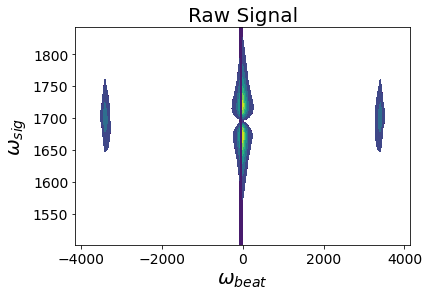

In [29]:
def plot_fft(b):
    global SpecMat
    global fSpecMat
    global vaxis_tau
    global tauStep
    fSpecMat = np.fft.fft(SpecMat, axis=1)
    vaxis_tau = np.fft.fftfreq(len(Tau))/(c*tauStep)

    plt.figure(1)
    plt.contourf(vaxis_tau, vaxis[ndx1:ndx2],np.abs(fSpecMat))
    plt.xlabel('$\omega_{beat}$', fontsize=20)
    plt.ylabel('$\omega_{sig}$', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Raw Signal', fontsize=20)
    plt.show()
    
plotfft_button = widgets.Button(
    description='Plot FFT',
    disabled=False
)

plotfft_button.on_click(plot_fft)
display.display(plotfft_button)


Our signal has two main frequency components in the $\omega_{beat}$ axis, corresponding to $\omega_{beat} = 0$ and $\omega_{beat} \approx 3300$ cm$^{-1}$, i.e. twice the Morse oscillator frequency. The low-frequency component is exactly the pump-probe signal that we're trying to simulate. The high-frequency component corresponds instead to the **double quantum coherence** signal associated with the wavevector sum
$${\bf k}_\text{sig} = {\bf k}_1 + {\bf k}_2 - {\bf k}_3. $$
In a real-pump-probe experiment, the double-quantum coherence pathway emits in a different phase-matched direction from the pump-probe signal. 

Unfortunately, we can't directly model that phase-matching process with our single-oscillator simulation. We can, however, remove the signal via Fourier filtering. In fact, all we have to do is multiply the frequency domain signal by a window that is equal to one at low frequencies and zero at high frequencies. The simplest such filter is a simple step-function implemented in the code below as the logical comparison ``(np.abs(vaxis_tau)<500)`` which evaluates to 0 if the absolute value of the frequency axis is less than 500 cm$^{-1}$ and to 1 if the absolute value is greater than 500 cm$^{-1}$. 

Button(description='Filter FFT', style=ButtonStyle())

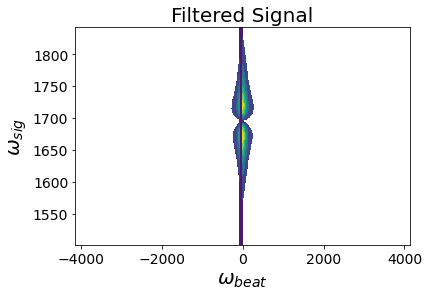

In [31]:
def plot_filtered(b):
    global vaxis_tau
    global fSpecMat
    global fppMat

    window = (np.abs(vaxis_tau)<500)
    fppMat = fSpecMat*window

    plt.figure()
    plt.contourf(vaxis_tau, vaxis[ndx1:ndx2],np.abs(fppMat))
    plt.xlabel('$\omega_{beat}$', fontsize=20)
    plt.ylabel('$\omega_{sig}$', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Filtered Signal', fontsize=20)
    plt.show()
    
fppMat = []

plotfiltered_button = widgets.Button(
    description='Filter FFT',
    disabled=False
)

plotfiltered_button.on_click(plot_filtered)
display.display(plotfiltered_button)

Finally, by transforming back to the time domain, we generate a two-dimensional plot of pump-probe spectra (dispersed along $\omega_\text{sig}$) as a function of the delay time $\tau$. This signal does *not* oscillate in as a function of $\tau$, instead showing a slow exponential decay. We'll now try to understand what physical effects cause that decay -- and what effects don't. 

Button(description='Plot Pump-Probe', style=ButtonStyle())

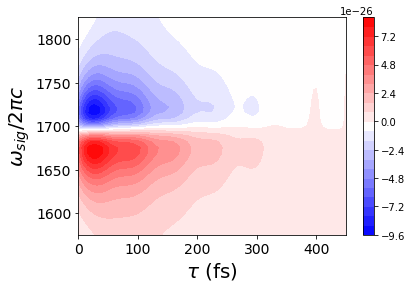

In [33]:
def plot_pp(b):

    ppMat = np.real(np.fft.ifft(fppMat, axis=1))

    plt.figure(3)
    plt.contourf(Tau*1e+15,vaxis[ndx1:ndx2], np.real(ppMat), 25)
    plt.set_cmap(plt.cm.get_cmap('bwr'))
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('$\\omega_{sig}/2\pi c$', fontsize=20)
    plt.xlabel('$\\tau$ (fs)', fontsize=20)
    plt.xlim([0, 450])
    plt.ylim([1575,1825])
    plt.colorbar()
    plt.show()
    
ppMat = []
plotpp_button = widgets.Button(
    description='Plot Pump-Probe',
    disabled=False
)

plotpp_button.on_click(plot_pp)
display.display(plotpp_button)

## Puting Everything Together: Dephasing vs. Dissipation ##

Finally, let's put all of our code together into a single simulation. The code below does exactly this, producing as the final output a fully-processed pump-probe time trace. In addition, the code incorporates a new parameter ``Nmols`` that allows for the simulation of an ensemble of oscillators with random frequencies. After examining the code, use it to answer the questions below. 

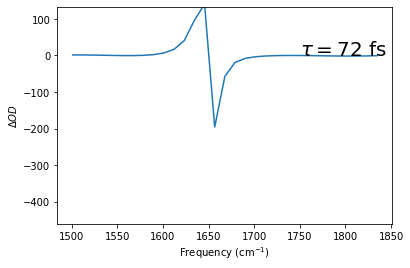

In [8]:
gamma_slider = widgets.FloatSlider(
    value=50,
    min=0,
    max=150,
    step=1.0,
    description='$\gamma$ (pg/s):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
    
temp_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=1000,
    step=1.0,
    description='T (K):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

emax_slider = widgets.FloatSlider(
    value=100,
    min=0,
    max=250,
    step=1.0,
    description='$E_{max}\cdot 10^{-4}$ (statV/cm):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tmax_slider = widgets.FloatSlider(
    value=3,
    min=0,
    max=10,
    step=1.0,
    description='$t_{max}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)


tau2max_slider = widgets.FloatSlider(
    value=500,
    min=0,
    max=1000,
    step=1,
    description='$\\tau_{2}^{(max)}$ (fs)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

vpulse_slider = widgets.FloatSlider(
    value=50.0,
    min=0,
    max=100,
    step=0.1,
    description='$\\nu_{pulse}$ (THz)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

nmol_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=500,
    step=1,
    description='N$_{mol}$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


sdf_bt = widgets.RadioButtons(
    options=['Binary', 'Normal'],
    value = 'Binary',
    description='SDF type:',
    disabled=False
)

tauswitch_slider = widgets.IntSlider(
    min=1,
    value=1000,
    max=1000,
    step=1,
    description='$\\tau_{switch}$ (fs)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)


def run_pp(b):
    gamma = gamma_slider.value*1e-12  # grams/second
    Temp = temp_slider.value          # K
    tmax = tmax_slider.value*1e-12      # Total simulation time in seconds
    Nmol = nmol_slider.value
    Npos = Nmol
    tau2max = tau2max_slider.value*1.0e-15
    tau_switch = tauswitch_slider.value*1.0e-15
    vpulse = vpulse_slider.value*1e+12                      # pulse frequency in Hz
    sdf_mode = sdf_bt.value

    Emax = 100e+4   # Maximum electric field in statV/cm
    
    def calc_accel(x,efield):
        ax = - 2.0*De*alpha*(np.exp(-alpha*x) - np.exp(-2.0*alpha*x))/M
        ax += Qo*efield/M
        #ax = -K*x/M
        return ax

    def vv_step(x,vx,ax,efield):
        axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,1)/M
        xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
        axnew = calc_accel(xnew,efield)
        vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
        return xnew,vxnew,axnew

    def gauss_pulse(t):
        return np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

    def morse_energy(X):
        return De*(1.0 - np.exp(-alpha*X))**2

    to = 150e-15
    sigma = 50e-15
    nu = 50e+12

    dt=2e-15     # Time-step in seconds
    Nsteps=int(tmax/dt)
    M=12*(1.66054e-24)   # Mass in g
    Qo = 4.803e-10         # Elementary charge in statCoulombs
    taxis = np.arange(0,Nsteps)*dt   # Time axis (array of time steps)

    kB = 1.38064852e-16                  # erg/K
    B = 1.0/(1.0 + 0.5*gamma*dt/M)
    A = B*(1.0 - 0.5*gamma*dt/M)

    # Frequency parameters
    wcenter = 6.28*50.0e12
    sigw = 0.025*wcenter
    
   # Oscillator (angular) frequency
    if sdf_mode=='Binary':
        wo = wcenter + 2.0*sigw*(np.round(np.random.random((Npos,)))-0.5)
    else:
        wo = np.random.normal(wcenter, sigw, (Npos,))

    De = 1e+5*(kB*300.0)

    c = 2.9979e+10
    vaxis = np.fft.fftfreq(Nsteps)/(dt*c)

    v1 = 1500
    v2 = 1850

    ndx1 = np.where(np.abs(vaxis-v1)==np.min(np.abs(vaxis-v1)))[0][0]
    ndx2 = np.where(np.abs(vaxis-v2)==np.min(np.abs(vaxis-v2)))[0][0]

    if Nmol>1:
        W = np.random.normal(wo, 0.025*wo, (Nmol))
    else:
        W = wo

    K = M*W**2
    alpha = np.sqrt(K/(2.0*De))
    def calc_response(Efield):
        X = np.zeros((Nmol))
        VX = np.zeros((Nmol))
        AX = calc_accel(X,Efield[0])
        Mu = np.zeros((Nsteps))
        for n in range(0,Nsteps):
            X,VX,AX = vv_step(X,VX,AX,Efield[n])
            Mu[n] = np.mean(X)*Qo
        return Mu


    tauStep = 4*1e-15
    Tau = np.arange(0.0e-15, tau2max, tauStep)
    scfac = 8e+24*(Emax/(50e+4))
    for n in range(0, len(Tau)):
        tau = Tau[n]
        Epump = Emax*gauss_pulse(taxis)
        Eprobe = Emax*gauss_pulse(taxis-tau)

        Mu21 = calc_response(2.0*Epump + Eprobe)
        Mu20 = calc_response(2.0*Epump)
        Mu11 = calc_response(Epump + Eprobe)
        Mu01 = calc_response(Eprobe)
        Mu10 = calc_response(Epump)

        MuPP = (Mu21 - 2.0*Mu11) - (Mu20 - 2.0*Mu10) + Mu01
        fMuPP = np.fft.fft(MuPP)
        fEprobe = np.fft.fft(Eprobe)

        Sig = -np.imag(fMuPP/fEprobe)

        if n==0:
            SpecMat = np.zeros((len(vaxis[ndx1:ndx2]),len(Tau)))
            ppPts, = plt.plot(vaxis[ndx1:ndx2], Sig[ndx1:ndx2]*scfac)
            plt.xlabel('Frequency (cm$^{-1}$)')
            plt.ylabel('$\Delta OD$')
            txt = plt.text(1750, 0.75, '$\\tau$ = 0 fs', fontsize=20)
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            ppPts.set_ydata(Sig[ndx1:ndx2]*scfac)
            txt.set_text('$\\tau = $'+str(int(tau*1e+15))+' fs')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    
        r = np.random.random((Npos,))
        pswitch = 2.0*dt/tau_switch
        switch_ndcs = np.where(r<pswitch)[0]
        if sdf_mode=='Binary':
            new_freqs = wcenter + 2.0*sigw*(np.round(np.random.random(np.shape(switch_ndcs)))-0.5)
        else:
            new_freqs = np.random.normal(wcenter, sigw, np.shape(switch_ndcs))
        if len(new_freqs)>0:
            wo[switch_ndcs] = new_freqs
            K = M*wo**2

        SpecMat[:,n] = Sig[ndx1:ndx2]

    fSpecMat = np.fft.fft(SpecMat, axis=1)
    vaxis_tau = np.fft.fftfreq(len(Tau))/(c*tauStep)
    window = (np.abs(vaxis_tau)<500)
    fppMat = fSpecMat*window
    ppMat = np.real(np.fft.ifft(fppMat, axis=1))

    plt.figure(3)
    plt.contourf(Tau*1e+15,vaxis[ndx1:ndx2], np.real(ppMat), 25)
    plt.set_cmap(plt.cm.get_cmap('bwr'))
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('$\\omega_{sig}/2\pi c$', fontsize=20)
    plt.xlabel('$\\tau$ (fs)', fontsize=20)
    #plt.xlim([0, 450])
    plt.ylim([1575,1825])
    plt.colorbar()
    plt.show()
    
    display.display(widgets.HBox([pulse_box, part_box]))
    display.display(widgets.HBox([tauswitch_slider, sdf_bt]))
    display.display(button)


button = widgets.Button(description="Go!")
button.on_click(run_pp)

pulse_box = widgets.VBox([tmax_slider, tau2max_slider, sdf_bt])
part_box = widgets.VBox([nmol_slider, gamma_slider, temp_slider, tauswitch_slider])

display.display(widgets.HBox([part_box, pulse_box]))
display.display(button)

## Questions ##

1. How does the pump-probe spectrum change with the damping coefficient $\gamma$? Try, for example, $\gamma = 100$ pg/s vs $\gamma = 200$ pg/s.  

2. How does the pump-probe spectrum change when the simulation includes randomized frequencies? (Youm may want to use a relatively small value for $\gamma$, e.g., 50 pg/s so that you can clearly see the effect of the frequency randomization.)

3. From your last two answers (and what you've learned in your previous exercises), name one advantage of nonlinear measurements over absorption spectroscopy. 

## Answers ##

1. Along the frequency axis $\omega_{sig}$, the signal broadens as $\gamma$ increases. Along the time axis $\tau$, the signal decays more quickly as $\gamma$ increases. Both effects result from the dissipation of the nonlinear polarization due to the friction. Note: Since our simulation has a temperature of zero (and thus no thermal fluctuations), $\gamma$ represents *only* dissipation in this simulation, making no contribution to dephasing.

2. The spectrum broadens along the frequency axis $\omega_{sig}$ **but remains unchanged** along the time axis $\tau$. This reflects an important characteristic of pump-probe spectroscopy: although the $\omega_{sig}$ width is sensitive to both dephasing **and** dissipation, the decay as a function of the inter-pulse delay $\tau$ is determined only by **dissipation**. 

3. These observations illustrate one of the key advantages of nonlinear spectroscopies: The ability to separate the contributions of dephasing and dissipation from each other by dispersing the signal along multiple time/frequency axes. 

Bonus: Note that hole-burning spectroscopy -- which can likewise be used to separate population decay from static dephasing (i.e., inhomogeneous broadening -- is also formally a third-order experiment since the "burn" event is triggered by two interactions with the burn laser and since the final absorption measurement involves one more interaction with the measuring excitation source. In fact, hole burning can in many ways be viewed as a low-temperature version of pump-probe spectroscopy, where the nonlinear response to the "pump" pulse (i.e., the continuous-wave laser) is locked in place by the ultra-low temperature of the system. In hole burning, of course, the system "excitation" corresponds to a change in transition **frequency** rather than to the population of an electronic excited state. 

## Appendix 1: Pump-Probe Spectroscopy in the Nonlinear Response Framework ##

Based just on the experimental setup for the experiment, let's try to identify where pump-probe spectroscopy fits into the nonlinear response framework we developed in lecture. Recall the sum condition we identified for the signal wavevector ${\bf k}_\text{sig}$ of an $N^\text{th}$-order process:
$${\bf k}_\text{sig} = {\bf k}_1 + {\bf k}_2 + ... + {\bf k}_N,$$
where each ${\bf k}_n$ (for $n=1,...,N$) must be (either plus or minus) a wavevector that appears in the incident field. In pump-probe spectroscopy, there are two input ${\bf k}$-vectors, one defining the propagation axis of the pump (${\bf k}_\text{pump}$) and the other defining the propagation axis of the probe (${\bf k}_\text{probe}$).

### Linear Signals Involved in the Pump-Probe Experiment ### 
Linear signals in our experiment must thus follow one of two possible vectors:

Linear Signal:$ \quad \quad \pm {\bf k}_\text{sig} = \left \{ \begin{matrix} {\bf k}_\text{pump} \\ {\bf k}_\text{probe} \end{matrix} \right .$

Since in a pump-probe experiment the signal is monitored along the probe axis ${\bf k}_\text{probe}$, only the second of these two signal vectors actually contributes to the measured signal. The corresponding term in the nonlinear polarization has a form
$$\tilde {\bf P}^{(1)}({\bf k}_\text{probe},\omega) = \chi^{(1)}(\omega) \tilde {\bf E}_\text{probe}({\bf k}_\text{probe}, \omega) $$
that is *independent of the pump pulse*. Since it thus contributes equally to both pump-on and pump-off spectra, it will be eliminated in the final pum-probe difference spectrum ("pump-on minus pump-off"). Thus pump-probe spectroscopy measures only *nonlinear* signal. 

### Third-Order Signals Monitored in the Pump-Probe Experiment ###

Skipping second-order signals (since they're usually symmetry-suppressed), the wavevector sum condition for third-order processes reads
$$ \pm {\bf k}_\text{sig} = {\bf k}_1 + {\bf k}_2 + {\bf k}_3,$$
where again each vector ${\bf k}_n$ must be either $\pm {\bf k}_\text{pump}$ or $\pm {\bf k}_\text{probe}$. Since in the pump-probe experiment the probe pulse comes *after* the pump, we can assume that ${\bf k}_3 = \pm {\bf k}_\text{probe}$. (Recall that ${\bf k}_3$ represents the *last* interaction between the sample and the electric field.) Furthermore, just like in the linear case, any nonlinear signals that depend *only* on the probe field will be subtracted out in the "pump-on minus pump-off" processing. As a result, there are only two possible combinations of laser wavevectors that give rise to signal in the probe direction in our experiment: 
\begin{align}{\bf k}_\text{sig} &= - {\bf k}_\text{pump} + {\bf k}_\text{pump} + {\bf k}_\text{probe} \\ &= + {\bf k}_\text{pump} - {\bf k}_\text{pump} + {\bf k}_\text{probe} , \end{align}
referred to respectively as the *rephasing* and *nonresphasing* pathways. It is these two signals that are measured in a pump-probe experiment!


### Relation to the Response Function ###
 
To see how these signals are related to the material response, recall our general frequency-domain expression for the nonlinear polarization:
\begin{align}
    \tilde{P}_\alpha^{(n)}({\bf k},\omega) &\approx \frac{1}{(2\pi)^{4(n-1)}}\sum_{\alpha_1, ..., \alpha_n}  \int d\omega_1 ... \int d\omega_n \int d{\bf k}_1 ... \int d{\bf k}_n \\
    &\times \delta \left( \omega_1 + ... + \omega_n - \omega \right) \delta \left( {\bf k}_1 + ... + {\bf k}_n - {\bf k} \right) \nonumber \\
    &\times \tilde R_{\alpha_1...\alpha_n\alpha}^{(n)}(\omega_1, ..., \omega_1 + ... + \omega_n) \nonumber \\
    & \times \tilde{E}_{\alpha_1}^{(\text{exc})}({\bf k}_1,\omega_1) ... \tilde{E}_{\alpha_n}^{(\text{exc})}({\bf k}_n,\omega_n) \nonumber .
\end{align}
For simplicity, we'll assume that all the polarization indices are the same in our experiment, i.e., both pulses are polarized along the same axis (say the $y$ axis) and the signal is monitored along the same axis. The signal-vectors we identified for pump-probe spectroscopy correspond to contributions to this integral when ${\bf k}_1 = - {\bf k}_2 = \pm {\bf k}_\text{pump}$ and ${\bf k}_3 = {\bf k}_\text{probe}$, i.e., 
\begin{align}
    \tilde{P}_y^{(\text{pp})}({\bf k}_\text{probe},\omega) &\approx \frac{1}{(2\pi)^{4}} \int d\omega_1 \int d\omega_2 \int d\omega_3 \delta \left( \omega_1 + \omega_2 + \omega_3 - \omega \right) \tilde R_{yyyy}^{(3)}(\omega_1, \omega_1 + \omega_2, \omega_1 + \omega_2 + \omega_3) \nonumber \\
    & \times \left [ \tilde{E}_{y}^{(\text{exc})}({\bf k}_\text{pump},\omega_1) \tilde{E}_{y}^{(\text{exc})}(-{\bf k}_\text{pump},\omega_2) \tilde{E}_{y}^{(\text{exc})}({\bf k}_\text{probe},\omega_3) + \tilde{E}_{y}^{(\text{exc})}(-{\bf k}_\text{pump},\omega_1) \tilde{E}_{y}^{(\text{exc})}({\bf k}_\text{pump},\omega_2) \tilde{E}_{y}^{(\text{exc})}({\bf k}_\text{probe},\omega_3) \right] 
\end{align}

Now, assuming that the input fields propagate along their positive ${\bf k}$-axes, the *signs* of the interaction vectors and interaction frequencies (at which the external field $\tilde{E}_{y}^{(\text{exc})}$ are evaluated) must be correlated: positive frequencies go with positive wavevectors and vice versa. This consideration dictates that the frequency $\omega_1 + \omega_2$ in the third-order response function must be approximately zero, since the signs on wavevectors ${\bf k}_1$ and ${\bf k}_2$ are opposite. In our expression, this corresponds to setting $\omega_1 = - \omega_2$ and eliminating one of the two integrals. 

Moreover, if the pulse spectra are broad enough, we can neglect their variation with frequency, so that 
\begin{align}
    \tilde{P}_y^{(\text{pp})}({\bf k}_\text{probe},\omega) &\propto \varepsilon_\text{pump}^2 \varepsilon_\text{probe} \int d\omega_1 \left [ \tilde R_{yyyy}^{(3)}(\omega_1, 0, \omega) + \tilde R_{yyyy}^{(3)}(-\omega_1, 0, \omega) \right],
\end{align}
where $\varepsilon_\text{pump}$ and $\varepsilon_\text{probe}$ are amplitudes for the pump and probe fields, respectively. 

## Appendix 2: Nonlinear Scaling ##

The *total* response of our system to the *total* field can be expressed (up to third order) as 
$$ {\bf P}[\varepsilon_\text{pu}, \varepsilon_\text{pr}] \approx \varepsilon_\text{pu} {\bf P}_\text{pu}^{(1)} + \varepsilon_\text{pr} {\bf P}_\text{pr}^{(1)}\\ + \varepsilon_\text{pu}^2 {\bf P}_\text{pu}^{(2)} + \varepsilon_\text{pu} \varepsilon_\text{pr} {\bf P}_\text{pu,pr}^{(2)} + \varepsilon_\text{pr}^2 {\bf P}_\text{pr}^{(2)} \\ + \varepsilon_\text{pu}^3 {\bf P}_\text{pu}^{(3)} + \varepsilon_\text{pu}^2 \varepsilon_\text{pr} {\bf P}_\text{2pu,pr}^{(3)} + \varepsilon_\text{pu} \varepsilon_\text{pr}^2 {\bf P}_\text{pu,2pr}^{(3)} + \varepsilon_\text{pr}^3 {\bf P}_\text{pr}^{(3)}. $$
Here the two terms on the first line represent the *linear response* to the two pulses. The second line represents the three possible forms of *second-order* interaction: two interactions with one pulse or one interaction with each pulse. The third line represents the three possibilities for *third-order* interactions: three interactions with one pulse or two interactions with one pulse and one interaction with the other. 

Excitation with the probe field only induces the polarization
$$ {\bf P}[0,\varepsilon_\text{pr}] \approx \varepsilon_\text{pr} {\bf P}_\text{pr}^{(1)} + \varepsilon_\text{pr}^2 {\bf P}_\text{pr}^{(2)} + \varepsilon_\text{pr}^3 {\bf P}_\text{pr}^{(3)} ,$$
while excitation with only the pump yields
$$ {\bf P}[\varepsilon_\text{pu},0] \approx \varepsilon_\text{pu} {\bf P}_\text{pu}^{(1)} + \varepsilon_\text{pu}^2 {\bf P}_\text{pu}^{(2)} + \varepsilon_\text{pu}^3 {\bf P}_\text{pu}^{(3)} .$$
Subtracting both of these signals from the total polarization leaves only those contributions that depend on the amplitude of *both* pulses:
$$ {\bf P}[\varepsilon_\text{pu},\varepsilon_\text{pr}] - {\bf P}[0,\varepsilon_\text{pr}] - {\bf P}[\varepsilon_\text{pu},0] \approx \varepsilon_\text{pu} \varepsilon_\text{pr} {\bf P}_\text{pu,pr}^{(2)} + \varepsilon_\text{pu}^2 \varepsilon_\text{pr} {\bf P}_\text{2pu,pr}^{(3)} + \varepsilon_\text{pu} \varepsilon_\text{pr}^2 {\bf P}_\text{pu,2pr}^{(3)} .$$
Finally, if we replace $\varepsilon_\text{pu}$ with $2 \varepsilon_\text{pu}$, we obtain the scaled quantity
$$ {\bf P}[2 \varepsilon_\text{pu},\varepsilon_\text{pr}] - {\bf P}[0,\varepsilon_\text{pr}] - {\bf P}[2 \varepsilon_\text{pu},0] \approx 2 \varepsilon_\text{pu} \varepsilon_\text{pr} {\bf P}_\text{pu,pr}^{(2)} + 4 \varepsilon_\text{pu}^2 \varepsilon_\text{pr} {\bf P}_\text{2pu,pr}^{(3)} + 2 \varepsilon_\text{pu} \varepsilon_\text{pr}^2 {\bf P}_\text{pu,2pr}^{(3)} .$$
Taking a (scaled) difference between the last two expressions gives an equation for only the signal that depends linearly on $\varepsilon_\text{pr}$ and *nonlinearly* and $\varepsilon_\text{pu}$: 
$${\bf P}[2 \varepsilon_\text{pu},\varepsilon_\text{pr}] - {\bf P}[0,\varepsilon_\text{pr}] - {\bf P}[2 \varepsilon_\text{pu},0] - 2 \left( {\bf P}[\varepsilon_\text{pu},\varepsilon_\text{pr}] - {\bf P}[0,\varepsilon_\text{pr}] - {\bf P}[\varepsilon_\text{pu},0] \right) \approx 2 \varepsilon_\text{pu}^2 \varepsilon_\text{pr} {\bf P}_\text{2pu,pr}^{(3)}  $$
